In [31]:
import numpy as np

results = np.load("/home/vhsingh/openfoam10-run/Geo-UPSplus/dataset_gen/CE-RP_openfoam_irregular/results.npy")

print(results.shape)

(1, 21, 16320, 4)


Loaded data with shape (1000, 21, 16320, 4) (simulations, time_steps, points, channels)


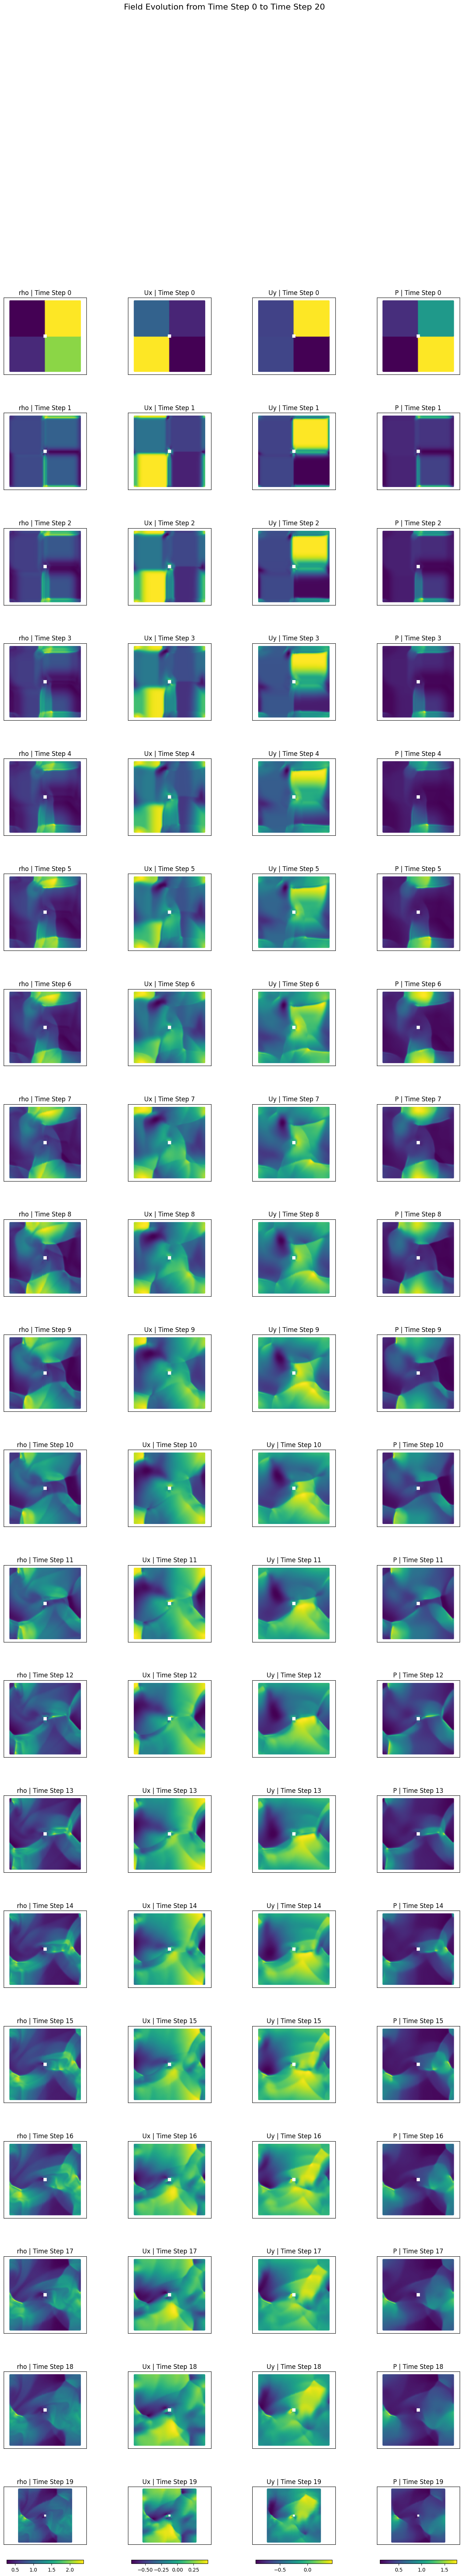

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def read_mesh_coordinates(file_path):
    """Reads mesh cell coordinates from the specified OpenFOAM C file."""
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Locate the start of the coordinates list
    start_index = None
    for i, line in enumerate(lines):
        if 'nonuniform List<vector>' in line:
            start_index = i + 2  # The data starts two lines after this
            break

    if start_index is None:
        raise ValueError("Start of coordinates data (nonuniform List<vector>) not found in the file.")

    coordinates = []
    for line in lines[start_index:]:
        line = line.strip()
        if line.startswith(')'):  # End of the list
            break
        if line.startswith('(') and line.endswith(')'):
            coord = line.strip('()').split()
            coordinates.append([float(c) for c in coord])

    return np.array(coordinates)

def plot_evolution(npy_file, point_coordinates, simulation_idx=0, time_steps=20):
    """
    Plots the evolution of fields (rho, Ux, Uy, P) from time step 0 to time_steps - 1.
    Each row corresponds to a time step, and each row has 4 columns, one for each field.

    Args:
        npy_file (str): Path to the `.npy` file containing the simulation data.
        point_coordinates (np.ndarray): Array of shape (num_points, 2) or (num_points, 3) containing point coordinates.
        simulation_idx (int): Index of the simulation to plot (default: 0).
        time_steps (int): Number of time steps to include in the plot (default: 20).

    Returns:
        None
    """
    # Channel mapping
    channels = ["rho", "Ux", "Uy", "P"]
    channel_map = {"rho": 0, "Ux": 1, "Uy": 2, "P": 3}
    
    # Load data
    data = np.load(npy_file)
    print(f"Loaded data with shape {data.shape} (simulations, time_steps, points, channels)")
    
    # Validate time steps
    if time_steps > data.shape[1]:
        raise ValueError(f"Requested {time_steps} time steps, but data only has {data.shape[1]} time steps.")
    
    # Extract coordinates
    x_coords = point_coordinates[:, 0]
    y_coords = point_coordinates[:, 1]
    
    # Create the plot grid
    fig, axes = plt.subplots(nrows=time_steps, ncols=len(channels), figsize=(16, 4 * time_steps))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for t_idx in range(time_steps):
        for c_idx, field_name in enumerate(channels):
            field_idx = channel_map[field_name]
            field_data = data[simulation_idx, t_idx, :, field_idx]  # Shape: (num_points,)
            
            # Get the axis
            ax = axes[t_idx, c_idx] if time_steps > 1 else axes[c_idx]
            
            # Scatter plot
            scatter = ax.scatter(x_coords, y_coords, c=field_data, cmap="viridis", s=5)
            ax.set_title(f"{field_name} | Time Step {t_idx}")
            ax.axis("equal")
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Add color bar to the last row
            if t_idx == time_steps - 1:
                fig.colorbar(scatter, ax=ax, orientation="horizontal", pad=0.2, fraction=0.05)

    # Add row and column labels
    fig.suptitle("Field Evolution from Time Step 0 to Time Step 20", fontsize=16)
    plt.show()

# Example usage
if __name__ == "__main__":
    # Parse coordinates
    c_file_path = "Design_Point_0_copy_1/0/C"
    point_coordinates = read_mesh_coordinates(c_file_path)

    # Plot evolution
    plot_evolution(npy_file="results.npy", point_coordinates=point_coordinates,
                   simulation_idx=0, time_steps=20)
